In [1]:
!pip install gensim==3.8.3
!pip install keras --upgrade
!pip install pandas --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 65.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 8.7 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.11.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████

In [2]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 553.8 MB 12 kB/s 
     |████████████████████████████████| 439 kB 69.3 MB/s 
     |████████████████████████████████| 5.7 MB 47.7 MB/s 
     |████████████████████████████████| 1.7 MB 61.9 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.11.23 which is incompatible.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.11.0 which is incompatible.


In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [58]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "/content/drive/MyDrive/Twitter/lstm_model/model.h5"
WORD2VEC_MODEL = "/content/drive/MyDrive/Twitter/lstm_model/model.w2v"
TOKENIZER_MODEL = "/content/drive/MyDrive/Twitter/lstm_model/tokenizer.pkl"
ENCODER_MODEL = "/content/drive/MyDrive/Twitter/lstm_model/encoder.pkl"

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# df = pd.read_csv('/content/drive/MyDrive/Twitter/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df = pd.read_csv('/content/drive/MyDrive/Twitter/training.1600000.processed.noemoticon.csv', encoding = "latin-1", low_memory=False)

In [8]:
print("Dataset size:", len(df))

Dataset size: 50000


In [9]:
print(df.columns)
print(df.head(2))

Index(['ids', 'date', 'user', 'text', 'target'], dtype='object')
          ids                          date            user  \
0  2265878782  Sun Jun 21 07:29:15 PDT 2009         MeeJong   
1  2205565064  Wed Jun 17 05:00:35 PDT 2009  kathysyahrizal   

                                                text  target  
0  This morning my daughter asked me if I hate my...       0  
1     I forgot to charge my bb, zzzzz only 35% left        0  


In [10]:
# randomly sample 25000 rows with target == 0, and 25000 rows with target == 4
neg_df = df[df.target == 0].sample(n=25000, random_state=5)
pos_df = df[df.target == 4].sample(n=25000, random_state=5)

In [11]:
neg_df.head()

,ids,date,user,text,target
12653,2298722903,Tue Jun 23 12:02:00 PDT 2009,i_live_in_a_box,because you thought they did,0
22745,1978271279,Sat May 30 22:53:08 PDT 2009,jennac0re,"@xsparkage almost every morning, actually. it ...",0
18675,2203622372,Wed Jun 17 00:09:10 PDT 2009,shoeaddictk8,"Can't sleep, watching confessions of a shopaho...",0
23488,1573555950,Tue Apr 21 01:44:00 PDT 2009,MConlon,Yay preliminary analysis is done - presentatio...,0
5580,2175942206,Mon Jun 15 02:27:00 PDT 2009,Handsets,ICC getting shirty with Voda in India http:...,0


In [12]:
pos_df.head()

,ids,date,user,text,target
37653,2002074036,Tue Jun 02 03:03:20 PDT 2009,mp3mad,@winterchick12 Thanks for following Chelsea. S...,4
47745,2010644954,Tue Jun 02 17:43:47 PDT 2009,HalfassBackward,@CodeN1Nj4 Do you got any of that ICY HOT rub?...,4
43675,2053613403,Sat Jun 06 05:09:01 PDT 2009,Julia_oliveros,@aliyoopah i thought he already have a first k...,4
48488,2047674228,Fri Jun 05 14:00:25 PDT 2009,mleis,@lwcavallucci how did you know?,4
30580,2013889095,Tue Jun 02 23:51:35 PDT 2009,supernaani,I think I'll sleep now. good night. cheeses! :...,4


In [13]:
decode_map = {0: "NEGATIVE", 2:"NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

Text(0.5, 1.0, 'Dataset labels distribuition')

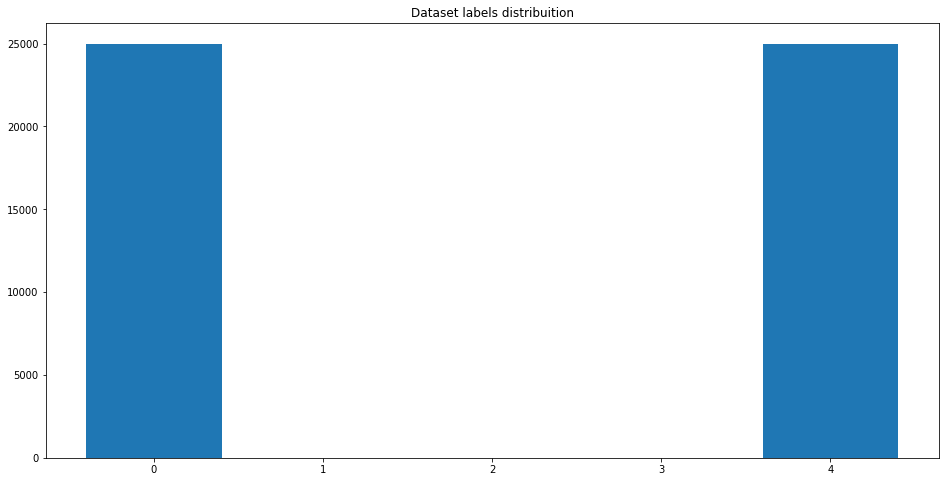

In [14]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [15]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In [16]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [17]:
print(df.head())

          ids                          date            user  \
0  2265878782  Sun Jun 21 07:29:15 PDT 2009         MeeJong   
1  2205565064  Wed Jun 17 05:00:35 PDT 2009  kathysyahrizal   
2  2002872654  Tue Jun 02 05:22:07 PDT 2009         kgautam   
3  1835496893  Mon May 18 06:07:33 PDT 2009       thejanice   
4  1573596472  Tue Apr 21 01:55:46 PDT 2009    lucyxechelon   

                                                text  target  
0  This morning my daughter asked me if I hate my...       0  
1     I forgot to charge my bb, zzzzz only 35% left        0  
2  my MBP battery is fluctuating between dead to ...       0  
3  i really wish my landlord would call me back. ...       0  
4                                  mean blog people        0  


In [18]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1.75 s, sys: 0 ns, total: 1.75 s
Wall time: 1.81 s


In [19]:
w2v_model = gensim.models.word2vec.Word2Vec()

In [20]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 40000
TEST size: 10000


In [21]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 31.6 ms, sys: 10.6 ms, total: 42.2 ms
Wall time: 43.2 ms


In [22]:
w2v_model = gensim.models.word2vec.Word2Vec()

In [23]:
w2v_model.build_vocab(documents)

In [24]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 5860


In [25]:
print(w2v_model)

Word2Vec(vocab=5860, size=100, alpha=0.025)


In [26]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 20.4 s, sys: 140 ms, total: 20.6 s
Wall time: 12.1 s


(7361713, 9234176)

In [27]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 33103
CPU times: user 520 ms, sys: 13 ms, total: 533 ms
Wall time: 533 ms


In [28]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 588 ms, sys: 13.8 ms, total: 602 ms
Wall time: 605 ms


In [29]:
# labels = df_train.target.unique().tolist()
# WHAT WE SHOULD TRY
labels = ["POSITIVE", "NEVATIVE", "NEUTRAL"]
labels

['POSITIVE', 'NEVATIVE', 'NEUTRAL']

In [30]:
for element in labels:
  print(type(element))

<class 'str'>
<class 'str'>
<class 'str'>


In [31]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


In [32]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)

x_test (10000, 300)
y_test (10000, 1)


In [33]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [34]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(33103, 100)


In [35]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [36]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          3310300   
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 3,390,801
Trainable params: 80,501
Non-trainable params: 3,310,300
_________________________________________________________________


In [37]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [38]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [39]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
36/36 [==============================] - 74s 2s/step - loss: 0.6269 - accuracy: 0.6434 - val_loss: 0.5576 - val_accuracy: 0.7110 - lr: 0.0010
Epoch 2/8
36/36 [==============================] - 51s 1s/step - loss: 0.5889 - accuracy: 0.6844 - val_loss: 0.5456 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 3/8
36/36 [==============================] - 49s 1s/step - loss: 0.5791 - accuracy: 0.6946 - val_loss: 0.5408 - val_accuracy: 0.7253 - lr: 0.0010
Epoch 4/8
36/36 [==============================] - 46s 1s/step - loss: 0.5718 - accuracy: 0.6989 - val_loss: 0.5364 - val_accuracy: 0.7272 - lr: 0.0010
Epoch 5/8
36/36 [==============================] - 46s 1s/step - loss: 0.5644 - accuracy: 0.7048 - val_loss: 0.5323 - val_accuracy: 0.7318 - lr: 0.0010
Epoch 6/8
36/36 [==============================] - 45s 1s/step - loss: 0.5583 - accuracy: 0.7112 - val_loss: 0.5316 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 7/8
36/36 [==============================] - 45s 1s/step - loss: 0.5551 - accuracy

In [40]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 1s 106ms/step - loss: 0.5171 - accuracy: 0.7420

ACCURACY: 0.7419999837875366
LOSS: 0.5170745849609375
CPU times: user 1.14 s, sys: 25.6 ms, total: 1.17 s
Wall time: 1.33 s


In [41]:
print(history.history)

{'loss': [0.6269108057022095, 0.588942289352417, 0.5790988206863403, 0.571825385093689, 0.5644328594207764, 0.558287501335144, 0.5551445484161377, 0.5534664392471313], 'accuracy': [0.6434444189071655, 0.6843611001968384, 0.6946389079093933, 0.6988611221313477, 0.7048333287239075, 0.7111944556236267, 0.7138888835906982, 0.7136389017105103], 'val_loss': [0.5575700998306274, 0.5456452369689941, 0.5407813787460327, 0.5364335775375366, 0.5323483943939209, 0.5315646529197693, 0.5294063687324524, 0.5278260707855225], 'val_accuracy': [0.7110000252723694, 0.7222499847412109, 0.7252500057220459, 0.7272499799728394, 0.7317500114440918, 0.7294999957084656, 0.7297499775886536, 0.7302500009536743], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


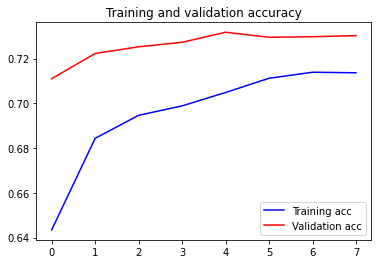

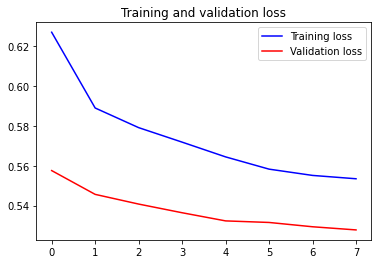

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [43]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [44]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [45]:
predict("I love the music")

1/1 [==============================] - 0s 320ms/step


{'label': 'POSITIVE',
 'score': 0.9197887778282166,
 'elapsed_time': 0.371659517288208}

In [46]:
predict("I hate the rain")

1/1 [==============================] - 0s 95ms/step


{'label': 'NEGATIVE',
 'score': 0.02438041940331459,
 'elapsed_time': 0.14034342765808105}

In [47]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 93ms/step


{'label': 'NEUTRAL',
 'score': 0.543209433555603,
 'elapsed_time': 0.13705873489379883}

In [48]:
print(df_test.target)

33553    4
9427     0
199      0
12447    0
39489    4
        ..
28567    4
25079    4
18707    0
15200    0
5857     0
Name: target, Length: 10000, dtype: int64


In [49]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
y_test_1d = [ "NEGATIVE" if y == 0 else "POSITIVE" if y == 4 else "NEUTRAL" for y in y_test_1d ]
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 1s 139ms/step
CPU times: user 660 ms, sys: 135 ms, total: 795 ms
Wall time: 909 ms


In [50]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

['POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'PO

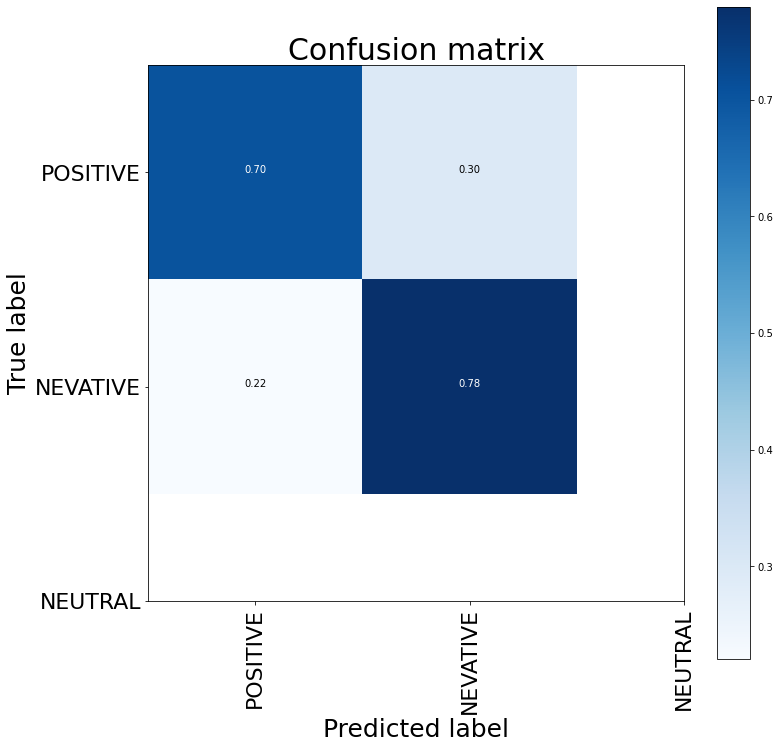

CPU times: user 256 ms, sys: 9.45 ms, total: 266 ms
Wall time: 276 ms


In [51]:
%%time
print(y_test_1d)
print(y_pred_1d)
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=labels, title="Confusion matrix")
plt.show()

In [52]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.76      0.70      0.73      5022
    POSITIVE       0.72      0.78      0.75      4978

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [53]:
accuracy_score(y_test_1d, y_pred_1d)

0.742

In [59]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [57]:
from google.colab import files
files.download('/content/drive/MyDrive/Twitter/lstm_model/model.h5')
files.download('/content/drive/MyDrive/Twitter/lstm_model/model.w2v')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
# tweets regarding the politicans
mehmet_oz_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/adam_laxalt.csv")
john_fetterman_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/john_fetterman.csv")
adam_laxalt_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/adam_laxalt.csv")
catherine_cortez_masto_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/catherine_cortez_masto.csv")
ron_johnson_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/ron_johnson.csv")
mandela_barnes_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/mandela_barnes.csv")
donald_bolduc_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/donald_bolduc.csv")
maggie_hassan_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/maggie_hassan.csv")
ted_budd_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/ted_budd.csv")
cheri_beasly_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/cheri_beasly.csv")
joe_pinion_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/joe_pinion.csv")
charles_schumer_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/charles_schumer.csv")
jd_vance_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/jd_vance.csv")
tim_ryan_df = pd.read_csv("/content/drive/MyDrive/Twitter/twitter_api_data/original/tim_ryan.csv")

In [ ]:
# run model on tweets
mehmet_oz_df['sentiment'] = mehmet_oz_df['Tweet'].apply(lambda x: predict(x)['label'])
john_fetterman_df['sentiment'] = john_fetterman_df['Tweet'].apply(lambda x: predict(x)['label'])
adam_laxalt_df['sentiment'] = adam_laxalt_df['Tweet'].apply(lambda x: predict(x)['label'])
catherine_cortez_masto_df['sentiment'] = catherine_cortez_masto_df['Tweet'].apply(lambda x: predict(x)['label'])
ron_johnson_df['sentiment'] = ron_johnson_df['Tweet'].apply(lambda x: predict(x)['label'])
mandela_barnes_df['sentiment'] = mandela_barnes_df['Tweet'].apply(lambda x: predict(x)['label'])
donald_bolduc_df['sentiment'] = donald_bolduc_df['Tweet'].apply(lambda x: predict(x)['label'])
maggie_hassan_df['sentiment'] = maggie_hassan_df['Tweet'].apply(lambda x: predict(x)['label'])
ted_budd_df['sentiment'] = ted_budd_df['Tweet'].apply(lambda x: predict(x)['label'])
cheri_beasly_df['sentiment'] = cheri_beasly_df['Tweet'].apply(lambda x: predict(x)['label'])
joe_pinion_df['sentiment'] = joe_pinion_df['Tweet'].apply(lambda x: predict(x)['label'])
charles_schumer_df['sentiment'] = charles_schumer_df['Tweet'].apply(lambda x: predict(x)['label'])
jd_vance_df['sentiment'] = jd_vance_df['Tweet'].apply(lambda x: predict(x)['label'])
tim_ryan_df['sentiment'] = tim_ryan_df['Tweet'].apply(lambda x: predict(x)['label'])

In [68]:
# save to csv
mehmet_oz_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/adam_laxalt_sentiment.csv")
john_fetterman_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/john_fetterman_sentiment.csv")
adam_laxalt_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/adam_laxalt_sentiment.csv")
catherine_cortez_masto_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/catherine_cortez_masto_sentiment.csv")
ron_johnson_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/ron_johnson_sentiment.csv")
mandela_barnes_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/mandela_barnes_sentiment.csv")
donald_bolduc_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/donald_bolduc_sentiment.csv")
maggie_hassan_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/maggie_hassan_sentiment.csv")
ted_budd_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/ted_budd_sentiment.csv")
cheri_beasly_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/cheri_beasly_sentiment.csv")
joe_pinion_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/joe_pinion_sentiment.csv")
charles_schumer_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/charles_schumer_sentiment.csv")
jd_vance_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/jd_vance_sentiment.csv")
tim_ryan_df.to_csv("/content/drive/MyDrive/Twitter/twitter_api_data/lstm_annotated/tim_ryan_sentiment.csv")

In [73]:
# get number of positive and negatives tweets from each df
def get_sentiment(df):
    pos = 0
    neg = 0
    for index, row in df.iterrows():
        if row['sentiment'] == "POSITIVE":
            neg += 1
        else:
            pos += 1
    return pos, neg

In [74]:
# get number of positive and negatives tweets from each df
pos, neg = get_sentiment(mehmet_oz_df)
print("Mehmet Oz: ", pos, neg)
pos, neg = get_sentiment(john_fetterman_df)
print("John Fetterman: ", pos, neg)
pos, neg = get_sentiment(adam_laxalt_df)
print("Adam Laxalt: ", pos, neg)
pos, neg = get_sentiment(catherine_cortez_masto_df)
print("Catherine Cortez Masto: ", pos, neg)
pos, neg = get_sentiment(ron_johnson_df)
print("Ron Johnson: ", pos, neg)
pos, neg = get_sentiment(mandela_barnes_df)
print("Mandela Barnes: ", pos, neg)
pos, neg = get_sentiment(donald_bolduc_df)
print("Donald Bolduc: ", pos, neg)
pos, neg = get_sentiment(maggie_hassan_df)
print("Maggie Hassan: ", pos, neg)
pos, neg = get_sentiment(ted_budd_df)
print("Ted Budd: ", pos, neg)
pos, neg = get_sentiment(cheri_beasly_df)
print("Cheri Beasley: ", pos, neg)
pos, neg = get_sentiment(joe_pinion_df)
print("Joe Pinion: ", pos, neg)
pos, neg = get_sentiment(charles_schumer_df)
print("Charles Schumer: ", pos, neg)
pos, neg = get_sentiment(jd_vance_df)
print("JD Vance: ", pos, neg)
pos, neg = get_sentiment(tim_ryan_df)
print("Tim Ryan: ", pos, neg)

Mehmet Oz:  125 95
John Fetterman:  255 245
Adam Laxalt:  125 95
Catherine Cortez Masto:  65 65
Ron Johnson:  495 5
Mandela Barnes:  380 60
Donald Bolduc:  15 10
Maggie Hassan:  125 5
Ted Budd:  470 30
Cheri Beasley:  150 15
Joe Pinion:  25 25
Charles Schumer:  65 110
JD Vance:  335 165
Tim Ryan:  270 230


In [75]:
# get pos/neg ,pos/all, neg/all ratio for all dfs
def get_ratios(df):
    pos, neg = get_sentiment(df)
    pos_all = pos / (pos + neg)
    neg_all = neg / (pos + neg)
    pos_neg = pos / neg
    # round all ratios to 2 decimal places
    pos_all = round(pos_all, 2)
    neg_all = round(neg_all, 2)
    pos_neg = round(pos_neg, 2)
    return pos_all, neg_all, pos_neg

In [76]:
pos_all, neg_all, pos_neg = get_ratios(mehmet_oz_df)
print("Mehmet Oz: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(john_fetterman_df)
print("John Fetterman: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(adam_laxalt_df)
print("Adam Laxalt: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(catherine_cortez_masto_df)
print("Catherine Cortez Masto: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(ron_johnson_df)
print("Ron Johnson: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(mandela_barnes_df)
print("Mandela Barnes: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(donald_bolduc_df)
print("Donald Bolduc: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(maggie_hassan_df)
print("Maggie Hassan: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(ted_budd_df)
print("Ted Budd: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(cheri_beasly_df)
print("Cheri Beasley: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(joe_pinion_df)
print("Joe Pinion: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(charles_schumer_df)
print("Charles Schumer: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(jd_vance_df)
print("JD Vance: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = get_ratios(tim_ryan_df)
print("Tim Ryan: ", pos_all, neg_all, pos_neg)

Mehmet Oz:  0.57 0.43 1.32
John Fetterman:  0.51 0.49 1.04
Adam Laxalt:  0.57 0.43 1.32
Catherine Cortez Masto:  0.5 0.5 1.0
Ron Johnson:  0.99 0.01 99.0
Mandela Barnes:  0.86 0.14 6.33
Donald Bolduc:  0.6 0.4 1.5
Maggie Hassan:  0.96 0.04 25.0
Ted Budd:  0.94 0.06 15.67
Cheri Beasley:  0.91 0.09 10.0
Joe Pinion:  0.5 0.5 1.0
Charles Schumer:  0.37 0.63 0.59
JD Vance:  0.67 0.33 2.03
Tim Ryan:  0.54 0.46 1.17


In [77]:
# winners vs losers
# winners: john fetterman, catherine cortez masto, ron johnson, maggie hassan, ted budd, charles schumer, jd vance
# losers: mehmet oz, adam laxalt, mandela barnes, donald bolduc, cheri beasley, joe pinion, tim ryan
winners = [john_fetterman_df, catherine_cortez_masto_df, ron_johnson_df, maggie_hassan_df, ted_budd_df, charles_schumer_df, jd_vance_df]
losers = [mehmet_oz_df, adam_laxalt_df, mandela_barnes_df, donald_bolduc_df, cheri_beasly_df, joe_pinion_df, tim_ryan_df]

In [78]:
# sum number of positive and negatives tweets from list of df
def sum_sentiment(dfs):
    pos = 0
    neg = 0
    for df in dfs:
        pos_df, neg_df = get_sentiment(df)
        pos += pos_df
        neg += neg_df
    return pos, neg

In [79]:
pos, neg = sum_sentiment(winners)
print("Winners: ", pos, neg)
pos, neg = sum_sentiment(losers)
print("Losers: ", pos, neg)

Winners:  1810 625
Losers:  1090 530


In [80]:
# average the ratios of winners and losers
def avg_ratios(dfs):
    pos_all = 0
    neg_all = 0
    pos_neg = 0
    for df in dfs:
        pos_all_df, neg_all_df, pos_neg_df = get_ratios(df)
        pos_all += pos_all_df
        neg_all += neg_all_df
        pos_neg += pos_neg_df
    pos_all = pos_all / len(dfs)
    neg_all = neg_all / len(dfs)
    pos_neg = pos_neg / len(dfs)
    return pos_all, neg_all, pos_neg

In [81]:
pos_all, neg_all, pos_neg = avg_ratios(winners)
print("Winners: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = avg_ratios(losers)
print("Losers: ", pos_all, neg_all, pos_neg)

Winners:  0.7057142857142856 0.2942857142857143 20.618571428571432
Losers:  0.65 0.35000000000000003 3.2342857142857144


In [82]:
# democrats vs republicans
# democrats: mehmet oz, adam laxalt, ron johnson, donald bolduc, ted budd, joe pinion, jd vance
# republicans: john fetterman, catherine cortez masto, mandela barnes, maggie hassan, cheri beasley, charles schumer, tim ryan
dems = [mehmet_oz_df, adam_laxalt_df, ron_johnson_df, donald_bolduc_df, ted_budd_df, joe_pinion_df, jd_vance_df]
reps = [john_fetterman_df, catherine_cortez_masto_df, mandela_barnes_df, maggie_hassan_df, cheri_beasly_df, charles_schumer_df, tim_ryan_df]

In [83]:
pos, neg = sum_sentiment(dems)
print("Democrats: ", pos, neg)
pos, neg = sum_sentiment(reps)
print("Republicans: ", pos, neg)

Democrats:  1590 425
Republicans:  1310 730


In [84]:
pos_all, neg_all, pos_neg = avg_ratios(dems)
print("Democrats: ", pos_all, neg_all, pos_neg)
pos_all, neg_all, pos_neg = avg_ratios(reps)
print("Republicans: ", pos_all, neg_all, pos_neg)

Democrats:  0.6914285714285714 0.3085714285714286 17.405714285714286
Republicans:  0.6642857142857144 0.33571428571428574 6.447142857142858
